<a href="https://colab.research.google.com/github/Doquey/ICPTrajetoria/blob/main/ICPTrajetoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


# Problema: Com base em 30 Point clouds retirados de um sensor de um carro em movimento, desenhar a trajetoria desse carro utilizando o algoritimo ICP(Iterative Closest Point).

#SETUP BASICO

In [ ]:
!pip install pywavefront -q

In [ ]:
base_dir = '/content/drive/My Drive/Colab Notebooks/Daedalus Problemas/Problema 1/Points'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import pywavefront 
from sklearn.decomposition import PCA
import random
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
from scipy.linalg import svd

import numpy as np
from scipy.spatial.distance import cdist



---


Objetivo do problema: Desenvolver um algoritimo com base no algoritimo ICP que nos ajude a levar point clouds coletados em diferentes referenciais cartersianos, para um mesmo referencial base de forma a calcularmos a trajetoria percorrida pelo automovel.


---



 

---


Aqui utilizaremos o algoritimo ICP vanilla, ou seja a implementação mais basica do algoritimo. O unico preprocessamento que iremos fazer com os nossos point clouds é um random sampling para termos point clouds com a mesma quantidade de points de forma a facilitar os calculos e diminuir a necessidade de RAM.


---



Teoria por trás do algoritimo:
O ICP é, como o nome diz, um algoritimo iterativo que visa transformar dados de um referencial cartesiano a outro e minimizar a distância entre pontos equivalentes nesse novo referencial. Um exemplo desse algoritimo escrito em alto nivel seria:
sejam xn^ e yn^ dois conjuntos de pontos correspondentes de dois point clouds coletados em movimento, ou seja os dois possuem referenciais cartesianos distintos:

xn^ = [x1,....xn]
yn^ = [y1,.....yn]

nesse exemplo utilizaremos yn como referencial base para transformação, ou seja levaremos os pontos xn^ para o referencial cartesiano de yn^. Para isso precisamos de uma matriz de transformação(T_mat), composta por uma matriz de rotação(R) e um vetor de translação(t). Dessa forma os pontos xn^ serão transformados para o novo referencial cartesiano da seguinte forma:

xn_new = R*xn^ + t

lembre-se que os pontos xn^ e yn^ são pontos correspondentes, ou seja são os mesmos pontos ou caracteristicas de uma imagem no referencial global. Dessa forma o nosso objetivo com essas transformações é tal que nos leve a:

distância euclidiana (yn - xn_new) -> min 

ou seja, queremos fazer os pontos correspondentes de cada point cloud convergirem num mesmo ponto. Caso alcançemos esse feito, teremos uma matriz de rotação e um vetor de translação que nos serão uteis para estimar a pose do sensor, ou camera, no momento i+1 que seria o momento em que o point cloud que contem o conjunto xn^ foi extraido. Essa é uma maneira excelente de se estimar a trajetoria de um veiculo ou corpo qualquer equipado com algum sensor ou camera que gere point clouds, pois é relativamente facil de se implementar e não custa tanto ao computador.


#Utils

In [ ]:
#Função para fazer upload dos pontos
def get_points(base_dir):
    labels=[]
    points =[]
    for point in os.listdir(base_dir):
            point_path = os.path.join(base_dir,point)
            points.append(pywavefront.Wavefront(point_path))
    return points

#Função para fazer o random sampling
def random_sample(points_vertices,n):
  reformed_points = []
  for point in points_vertices:
    reformed_points.append(random.sample(point,n))
  return reformed_points




def best_fit_transform(A, B):
    

    # Retiramos o centro de massa dos pontos de forma a leva-los proximos ao mesmo.
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = (A - centroid_A).T
    BB = B - centroid_B

    #Retiramos a matriz de Rotação, aplicando um Single value decomposition a nossa matriz de covariância H.
    H = np.dot(AA, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)


    #Criamos o vetor de translação
    t = centroid_B.T - np.dot(R,centroid_A.T)

    #Criamos a matriz de transformação
    T = np.identity(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t

    return T, R, t


def icp(A, B, init_pose=None, max_iterations=10000, tolerance=0.0001):
    
    #Colocamos os pontos na forma homogênea.
    src = np.ones((4,A.shape[0]))
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)
    dst[0:3,:] = np.copy(B.T)
    if init_pose is not None:
      src = np.dot(init_pose, src)

    prev_error=0
    #instaciamos o algoritimo para achar os pontos mais proximos entre os dois point clouds.
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(dst[0:3,:].T)
    for i in range(max_iterations):

        # Achamos os pontos mais proximos entre os dois point clouds
        distances,indices = nbrs.kneighbors(src[0:3,:].T)
        indices = indices.flatten()

        # Computamos a matriz de transformação que leva os pontos do referencial do src ao referencial da dst
        T,_,_ = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)

        # Fazemos a transformação e substituimos os nossos pontos no src pelos novos pontos transformados
        src = np.dot(T, src)


        #checamos o erro medio da transformação de forma a verificar se o algoritimo convergiu
        mean_error = np.sum(distances) / distances.size
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error
    # Calculamos a matriz de transformação final, ou seja a transformação que fez o algoritimo convergir.
    T,_,_ = best_fit_transform(A, src[0:3,:].T)

    return T



#Função que utiliza as matrizes de transformação dadas pelo ICP para criar a trajetoria do veiculo

def trajetoria(point_clouds,plot=True):
  num_frames = len(point_clouds)
  T_tot = np.eye(4)
  trajectory = np.zeros((num_frames, 3, 4))
  trajectory[0] = T_tot[:3, :]
  T_initial = np.eye(4)
  for i,point in enumerate(point_clouds[1:]):
      T_mat = icp(np.array(point_clouds[i]),np.array(point_clouds[i-1]),init_pose=T_initial)
      T_tot = T_tot.dot(np.linalg.inv(T_mat))
      trajectory[i+1, :, :] = T_tot[:3, :]*(-1)
      xs = trajectory[:i+2, 0, 3]
      ys = trajectory[:i+2, 1, 3]
      zs = trajectory[:i+2, 2, 3]
      fig1 = plt.figure(figsize=(12,8))
      ax = fig1.add_subplot(111, projection='3d')
      ax.plot(xs,ys,zs, label='estimated', color='orange',marker='o')
  if plot:        
      plt.close()
        

    
  











Fazemos upload dos pontos 

In [ ]:
points = get_points(base_dir) 

In [ ]:
#Pegamos as coordenadas dos pontos em cada point cloud.
vertices =[]
for point in points:
    vertices.append(point.vertices) 



Retiramos uma random sample dos nossos pontos para servir ao algoritimo. Note que não utilizarei todos os dados, pois o google colab e nem meu computador teria capacidade de aguentar o consumo de RAM de uma operação assim.



In [ ]:
point_clouds = random_sample(vertices,40000)

Criamos a nossa trajetoria da forma convencional(levamos nosso ponto referencial, point_clouds[0], nos demais pontos e medimos a rotação e translação. Dai vem essa trajetoria.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

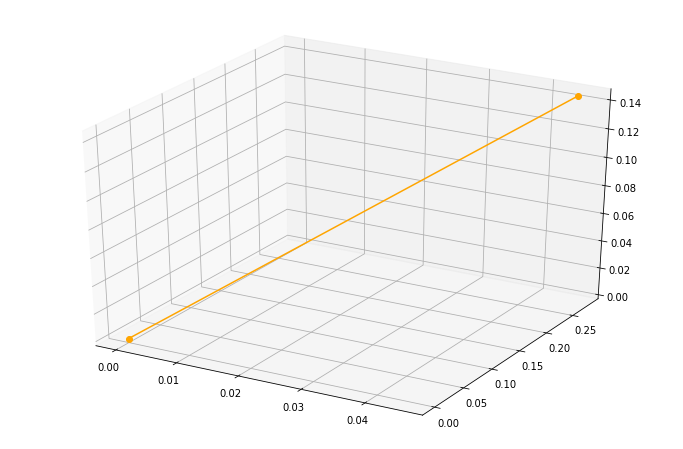

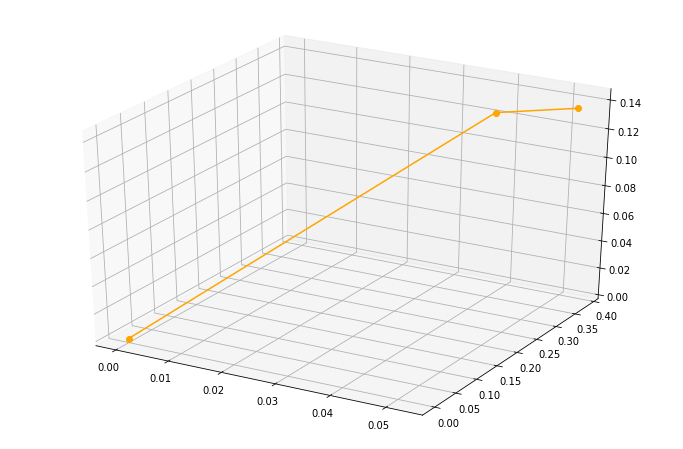

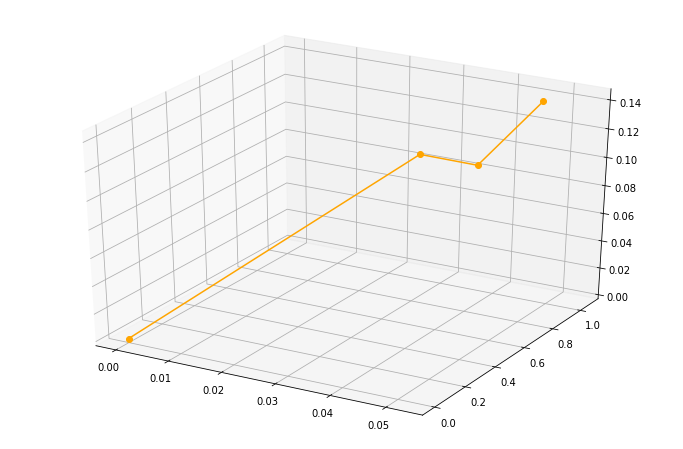

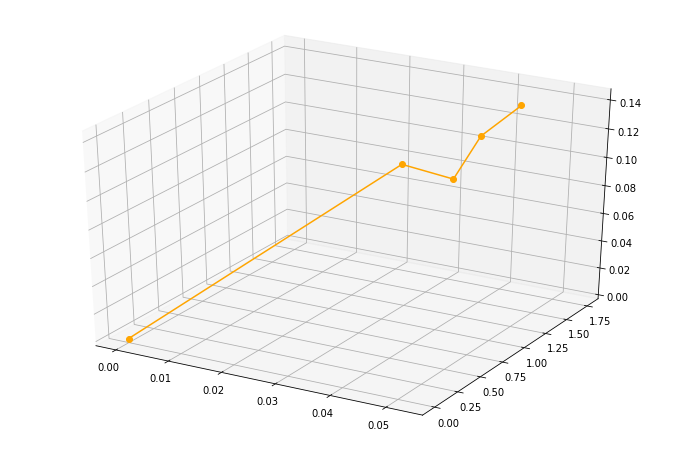

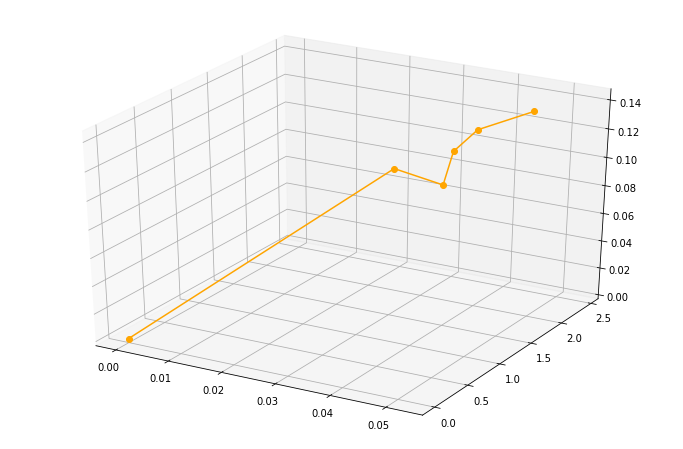

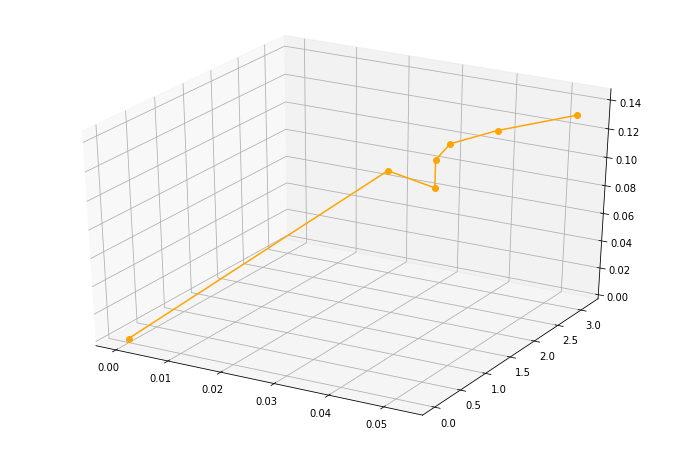

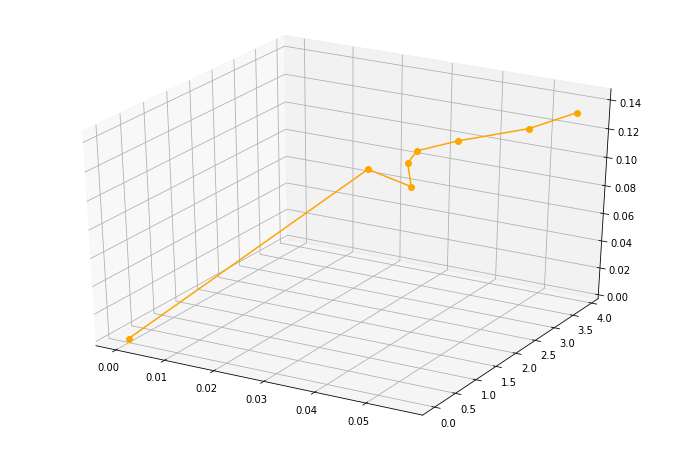

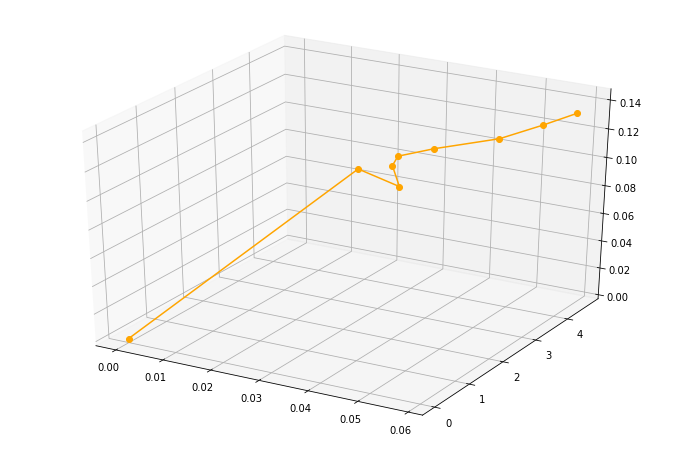

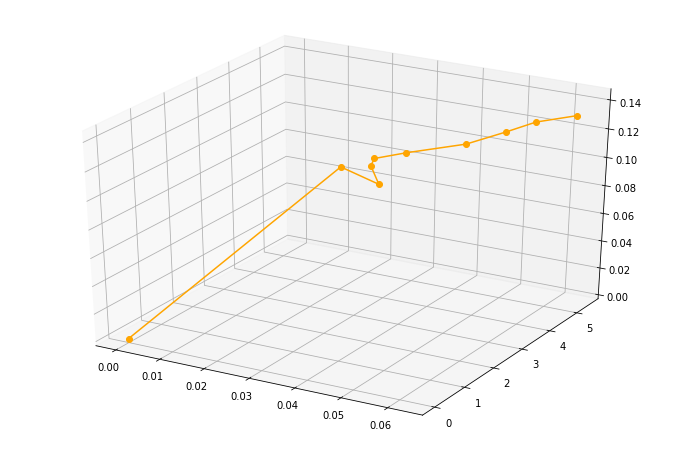

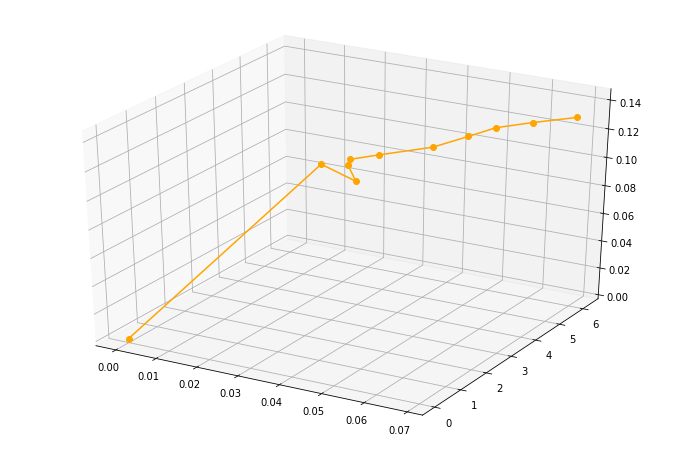

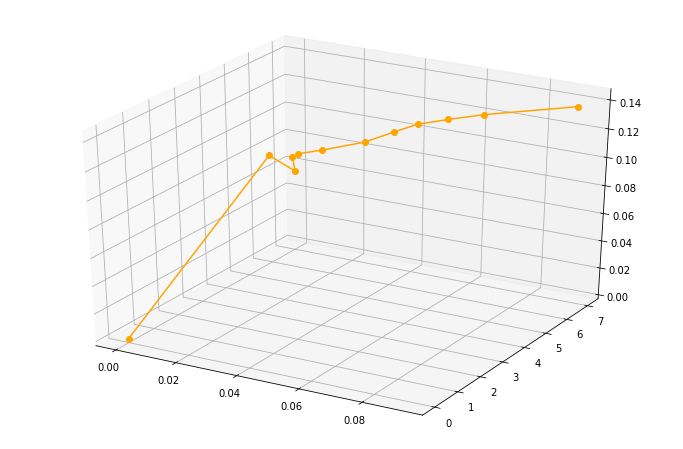

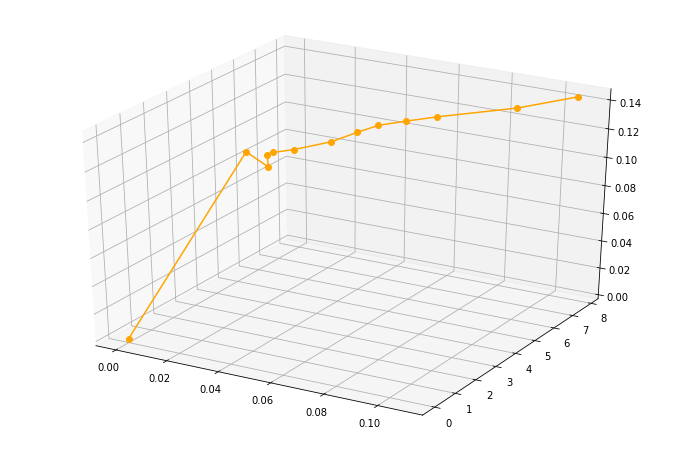

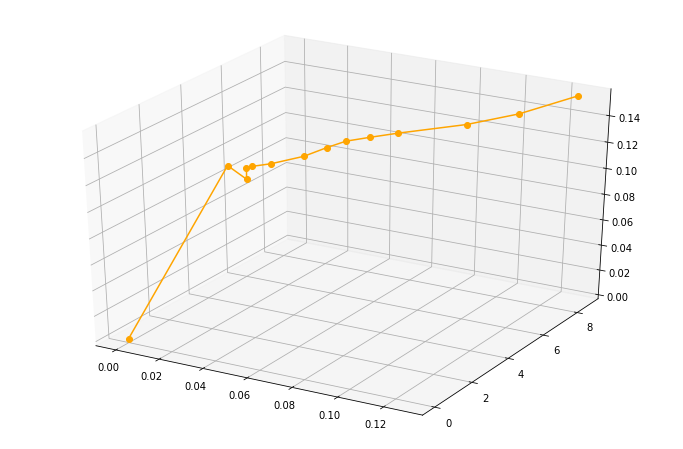

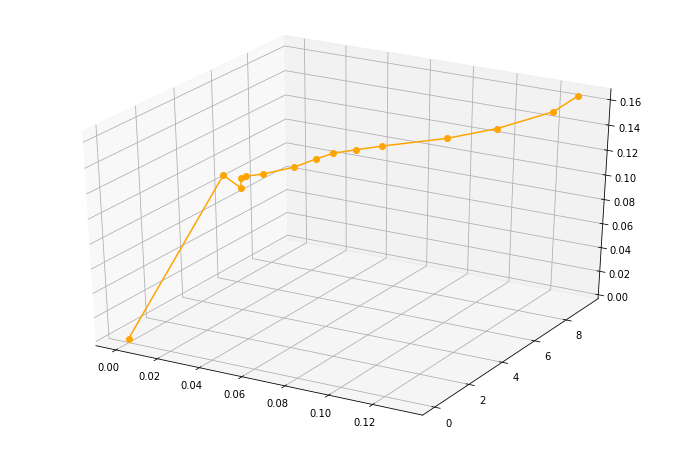

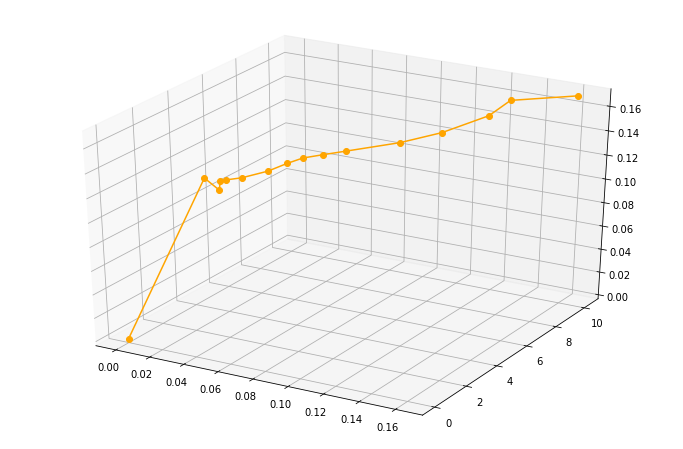

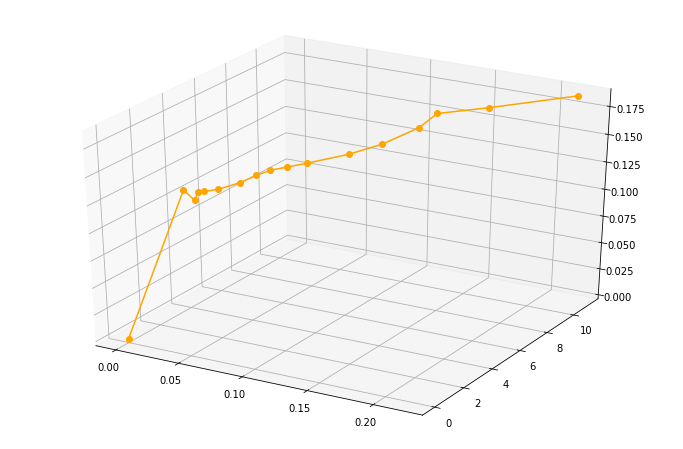

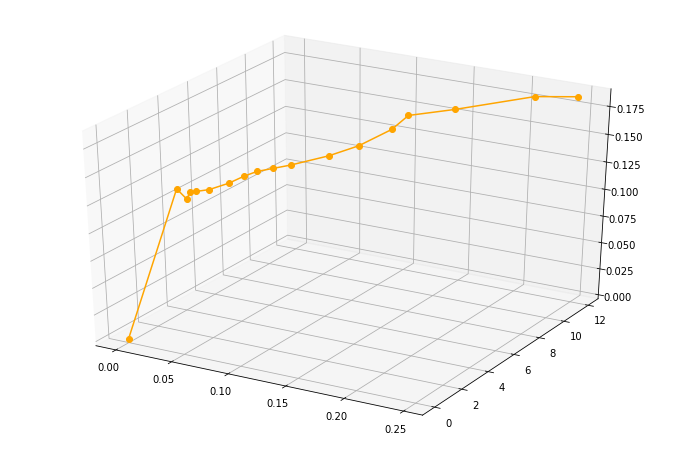

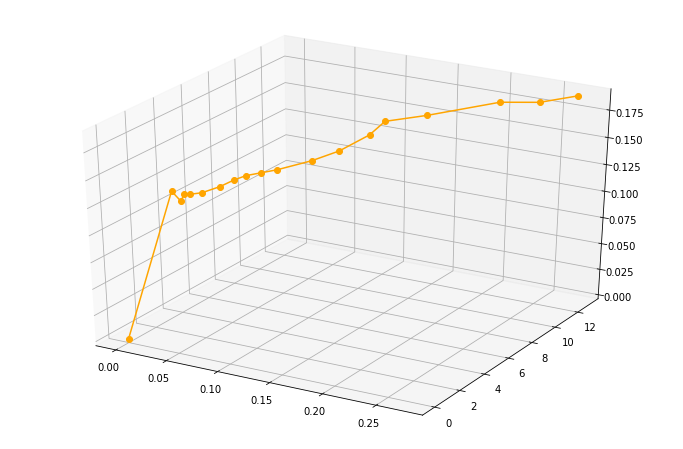

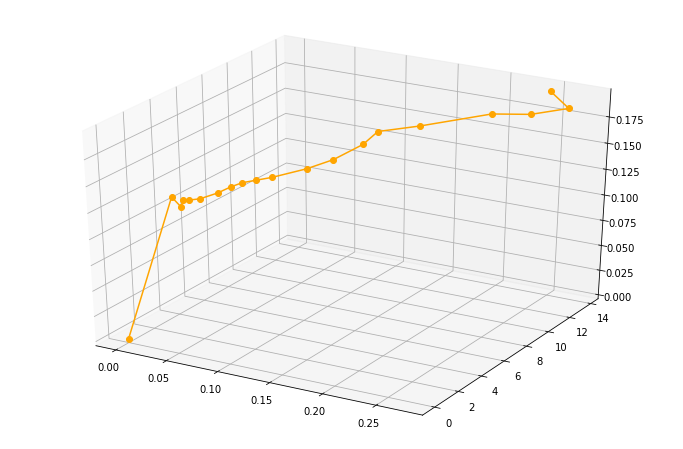

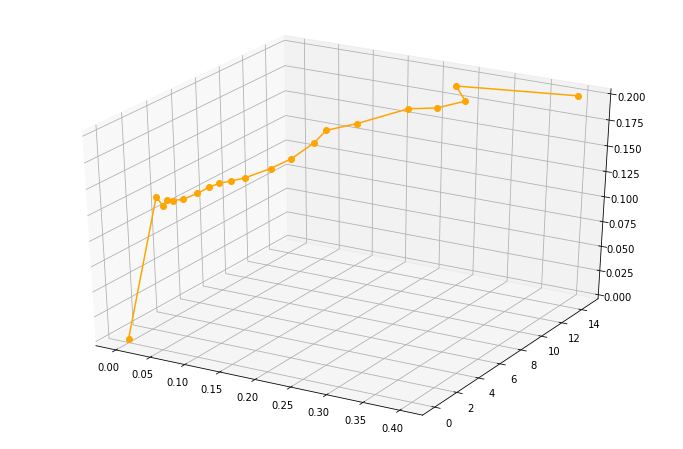

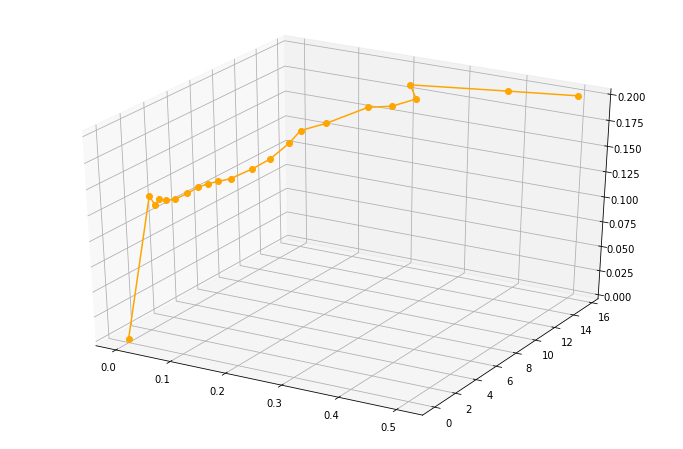

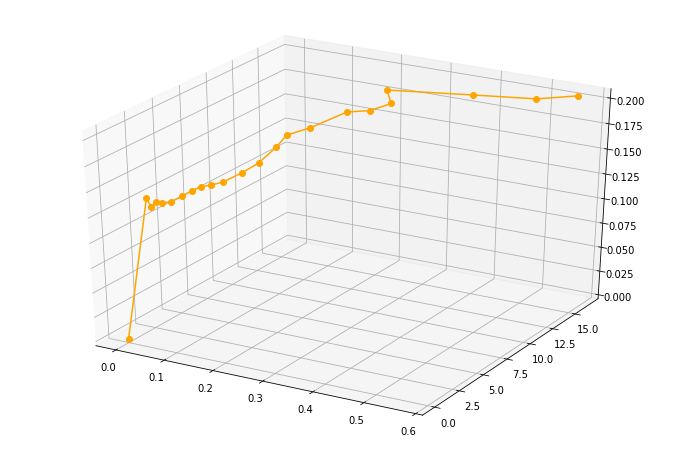

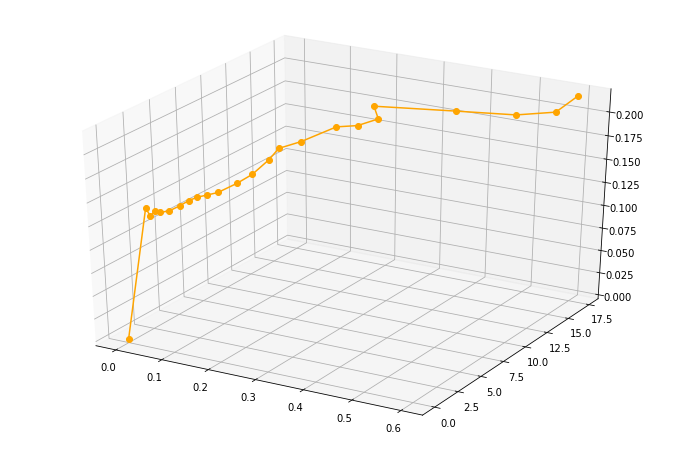

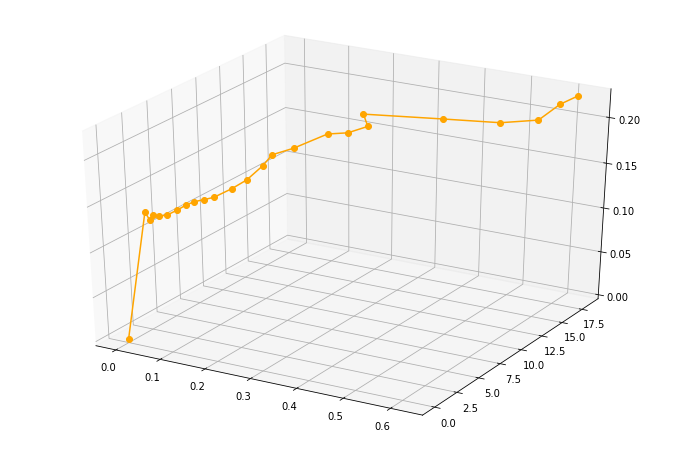

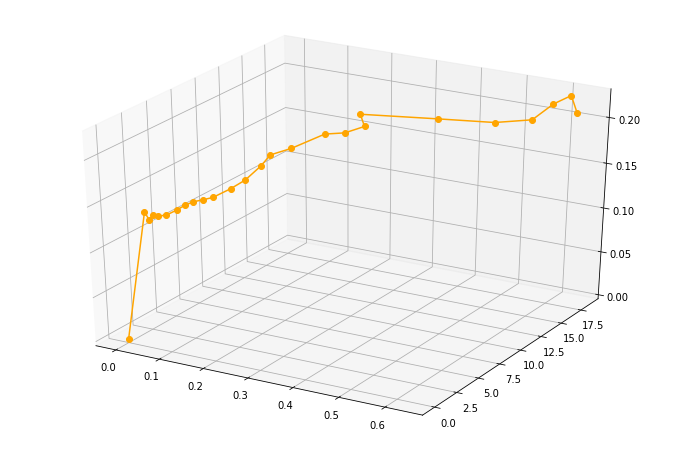

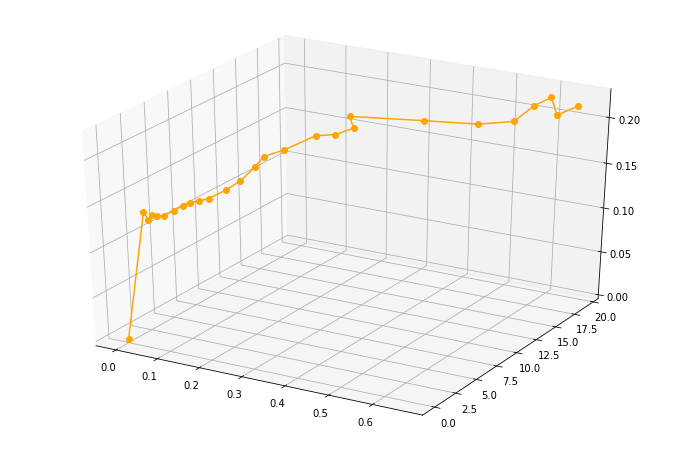

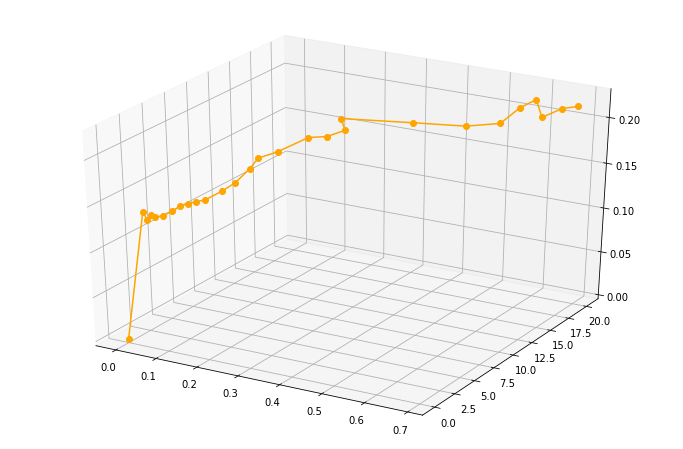

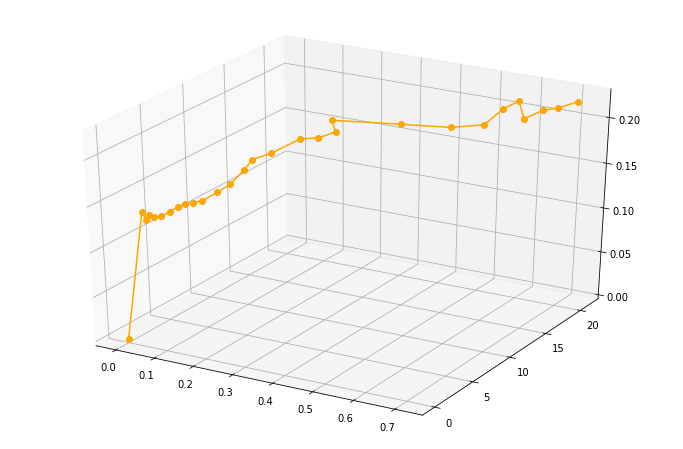

In [ ]:
trajetoria(point_clouds)

Conclução: 
A nossa aplicação funcionou, porem a trajetoria ficou levemente ruidosa. Uma forma de melhorar o algoritimo seria acrescentar alguns pesos para cada correspondência, cada par que o knn nos devolve, dessa forma conseguiriamos filtrar quais correspondências eram de maior importância para o modelo. 

Referências:

https://cs.gmu.edu/~kosecka/cs685/cs685-icp.pdf

https://www.yanivresearch.info/writtenMaterial/icp.pdf

https://www.youtube.com/watch?v=dhzLQfDBx2Q

